In [1]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os
import os
os.environ['HF_HOME'] = '/raid/users/mohammadibrahim-st/ModelCache'
torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

2024-09-10 11:23:42.358210: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-10 11:23:43.031780: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load the autoencoder model which will be used to decode the latents into image space.
import os
os.environ["https_proxy"] = "http://185.46.212.90:80"
os.environ["http_proxy"] = "http://185.46.212.90:80"
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

/home/mohammadibrahim-st/.local/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    # pil_images[0].save('/raid/users/mohammadibrahim-st/TSAI/Assignment24/Depth/mouseseed64bright.png')
    return pil_images

In [4]:
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32)

In [5]:
def brightness_loss(images, target_brightness=0.9):
    # Convert images to grayscale to calculate brightness
    grayscale_images = images.mean(dim=1, keepdim=True)
    error = torch.abs(grayscale_images - target_brightness).mean()
    return error


In [11]:
def generate_with_embs(text_embeddings):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 30            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(164)   # Seed generator to create the inital latent noise
    batch_size = 1
    blue_loss_scale=200

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        if i%5 == 0:
                # Requires grad on the latents
                latents = latents.detach().requires_grad_()

                # Get the predicted x0:
                latents_x0 = latents - sigma * noise_pred
                # latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

                # Decode to image space
                denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

                # Calculate loss
                loss = brightness_loss(denoised_images) * blue_loss_scale

                # Occasionally print it out
                if i%10==0:
                    print(i, 'loss:', loss.item())

                # Get gradient
                cond_grad = torch.autograd.grad(loss, latents)[0]

                # Modify the latents based on this gradient
                latents = latents.detach() - cond_grad * sigma**2

            # Now step with scheduler
        latents = scheduler.step(noise_pred, t, latents).prev_sample
    return latents_to_pil(latents)[0]

In [7]:
def build_causal_attention_mask(bsz, seq_len, dtype):
    # lazily create causal attention mask, with full attention between the vision tokens
    # pytorch uses additive attention mask; fill with -inf
    mask = torch.empty(bsz, seq_len, seq_len, dtype=dtype)
    mask.fill_(torch.tensor(torch.finfo(dtype).min))
    mask.triu_(1)  # zero out the lower diagonal
    mask = mask.unsqueeze(1)  # expand mask
    return mask
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

# out_embs_test = get_output_embeds(input_embeddings) # Feed through the model with our new function
# print(out_embs_test.shape) # Check the output shape
# out_embs_test # Inspect the output

In [19]:
current_directory = os.path.dirname(__file__)

# Construct the paths dynamically
birb_embed = torch.load(os.path.join(current_directory, 'Depth', 'learned_embeds.bin'))

birb_embedjerry = torch.load(os.path.join(current_directory, 'Jerry mouse', 'learned_embeds.bin'))

birb_embedmobius = torch.load(os.path.join(current_directory, 'Mobius', 'learned_embeds.bin'))

birb_embedoilpaint = torch.load(os.path.join(current_directory, 'Oil paint', 'learned_embeds.bin'))

birb_embedpolygon = torch.load(os.path.join(current_directory, 'Polygon', 'learned_embeds.bin'))

print(birb_embed.keys())
print(birb_embedjerry.keys())
print(birb_embedmobius.keys())
print(birb_embedoilpaint.keys())
print(birb_embedpolygon.keys())



dict_keys(['<depthmap>'])
dict_keys(['<jerrymouse>'])
dict_keys(['<moebius>'])
dict_keys(['oil_style'])
dict_keys(['<low-poly-hd-logos-icons>'])


/tmp/ipykernel_1959221/3185483617.py:23: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 85.86473846435547
10 loss: 24.20591926574707
20 loss: 24.945316314697266


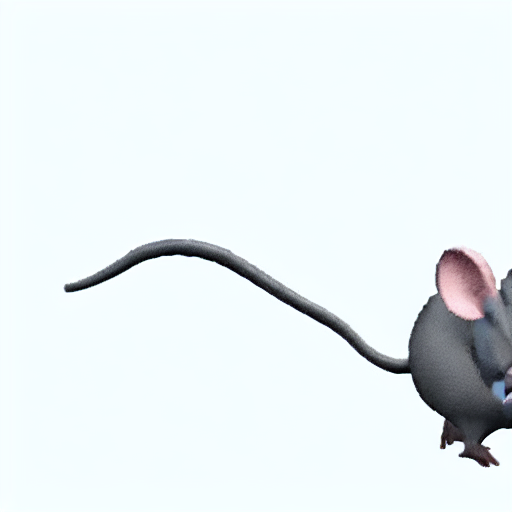

In [12]:
prompt = 'A mouse in the style of puppy'
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)
# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = birb_embed['<depthmap>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And generate an image with this:
a = generate_with_embs(modified_output_embeddings)
display(a)

In [21]:
import torch
import os
import gradio as gr

# Load the embeddings
# birb_embed = torch.load('/raid/users/mohammadibrahim-st/TSAI/Assignment24/Depth/learned_embeds.bin')
# birb_embedjerry = torch.load("/raid/users/mohammadibrahim-st/TSAI/Assignment24/Jerry mouse/learned_embeds.bin")
# birb_embedmobius = torch.load('/raid/users/mohammadibrahim-st/TSAI/Assignment24/Mobius/learned_embeds.bin')
# birb_embedoilpaint = torch.load('/raid/users/mohammadibrahim-st/TSAI/Assignment24/Oil paint/learned_embeds.bin')
# birb_embedpolygon = torch.load('/raid/users/mohammadibrahim-st/TSAI/Assignment24/Polygon/learned_embeds.bin')

# Set GRADIO temp directory
os.environ["GRADIO_TEMP_DIR"] = "/raid/users/mohammadibrahim-st/inpaintAppMemoryOptimised/tmp"

def generate_image(prompt, selected_embedding):
    # Map selected_embedding to corresponding embedding file and key
    embedding_dict = {
        "Depth": (birb_embed, '<depthmap>'),
        "Jerry mouse": (birb_embedjerry, '<jerrymouse>'),
        "Mobius": (birb_embedmobius, '<moebius>'),
        "Oil paint": (birb_embedoilpaint, 'oil_style'),
        "Polygon": (birb_embedpolygon, '<low-poly-hd-logos-icons>')
    }
    
    token_emb_layer = text_encoder.text_model.embeddings.token_embedding
    pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
    position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
    position_embeddings = pos_emb_layer(position_ids)

    # Tokenize
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    input_ids = text_input.input_ids.to(torch_device)

    # Get token embeddings
    token_embeddings = token_emb_layer(input_ids)

    # Select the appropriate birb embedding and key based on user input
    selected_embedding_file, embedding_key = embedding_dict[selected_embedding]
    replacement_token_embedding = selected_embedding_file[embedding_key].to(torch_device)

    # Insert this into the token embeddings
    token_embeddings[0, torch.where(input_ids[0] == 6829)] = replacement_token_embedding.to(torch_device)

    # Combine with pos embs
    input_embeddings = token_embeddings + position_embeddings

    # Feed through to get final output embs
    modified_output_embeddings = get_output_embeds(input_embeddings)

    # Generate an image with this and return it
    generated_image = generate_with_embs(modified_output_embeddings)
    return generated_image

# Define options for the dropdown
embedding_options = ["Depth", "Jerry mouse", "Mobius", "Oil paint", "Polygon"]

# Create Gradio interface
iface = gr.Interface(
    fn=generate_image, 
    inputs=[
        "text", 
        gr.Dropdown(choices=embedding_options, label="Select Style")
    ],
    outputs="image",
    title="Image Generation App (Please use the word 'puppy' in the prompt)"
)

iface.launch(share=True)


Running on local URL:  http://127.0.0.1:7865
IMPORTANT: You are using gradio version 4.24.0, however version 4.29.0 is available, please upgrade.
--------
Running on public URL: https://25baf7d4fc18ef497d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


/tmp/ipykernel_1959221/3185483617.py:23: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 49.29018783569336
10 loss: 14.723957061767578
20 loss: 14.416694641113281
